In [2]:
# -*- coding: utf-8 -*-
"""run_pkefeedback

Executes a simple transient package that includes:
    - Solution of point kinetic equations
    - Lumped conduction-convection problem
    - Change in reactivity

Created on Tue Oct 12 22:30:00 2021 @author: Dan Kotlyar
Last updated on Wed Oct 13 10:45:00 2021 @author: Dan Kotlyar
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings

warnings.filterwarnings("ignore")

from pkewithfeedback import SimpleTransient, plot1D


# Store kinetic parameters a designated dictionary
# -----------------------------------------------------------------------------
PKE = {}
beta1gr = 0.0075
PKE["beta"] = beta1gr * np.array([0.033, 0.219, 0.196, 0.395, 0.115, 0.042])
beta = PKE["beta"]
PKE["lamda"] = np.array([0.0124, 0.0305, 0.1110, 0.3011, 1.1400, 3.0100])
PKE["promptL"] = 0.001

# Store thermal properties in a designated dictionary
# -----------------------------------------------------------------------------
TH = {}
TH["C_F"] = 200.00     # J/kg/K
TH["C_M"] = 4000.0     # J/kg/K
TH["M_F"] = 40000.     # kg
TH["M_M"] = 7000.0     # kg
TH["W_M"] = 8000.0     # kg/sec
TH["Tin"] = 550.00     # K
TH["h"] = 4E+6         # J/K/sec

# Define metadata parameters and external reactivity scenario
# -----------------------------------------------------------------------------
P0 = 1500E+6     # Nominal power in Watts
P1 = 3000E+6     # Desired power uprate
aF = -1E-05      # drho/dTf
aM = -10E-05      # drho/dTm (associated with density change)

def ramp(magnitude, timepoints, ramp_time, start_time=0):
    index_tsec = np.argmin(np.abs(timepoints - ramp_time - start_time))
    index_start = np.argmin(np.abs(timepoints - start_time))
    rhoExt = np.zeros(len(timepoints))
    rhoExt[index_start:index_tsec+1] = np.linspace(0, magnitude*np.sum(beta), len(timepoints[index_start:index_tsec+1]))
    rhoExt[index_tsec+1:] = magnitude*np.sum(beta)*np.ones(len(timepoints[index_tsec+1:]))
    return rhoExt

simulationTime = 240 # s

#---------------------------------
# Defining the Objective Function
#---------------------------------
constraint_violation_penalty = 10

def find_final_time(P, P1, timepoints):
    """Finds the time at which the power is nearly constant (steady state) and equal to
    the desired power P1, if not found, return """
    
    power_uprate_acheived = np.isclose(P[1:]/1E+06, P1/1E+06, atol=10, equal_nan=False)

    derivative_estimate = (np.diff(P)/np.diff(timepoints))/1E+06
    steady_state_solution = np.isclose(0, derivative_estimate, atol=1e-1, equal_nan=False)
    if np.any(np.logical_and(power_uprate_acheived, steady_state_solution)):
        # Get first index where condition was met (the following points are not relevant)
        first_index = np.argmax(np.logical_and(power_uprate_acheived, steady_state_solution))
        return  (first_index, timepoints[first_index])
    else: # Condition was not met, return a distinctive output
        return (None, None)

def overshoot_constraints(rhoExt, P1, timepoints):
    X, T, rho, rhoF = SimpleTransient(timepoints, P0, rhoExt, PKE, TH, aF, 0.1E-05)
    final_time_index, final_time = find_final_time(X[0, :], P1, timepoints)
    if final_time_index is None and final_time is None:
        print("End point condition not satisfied")
        return -constraint_violation_penalty
    else:
        power_overshoot = np.max(X[0, 0:(final_time_index + 1)]) - P1
        reactivity_overshoot = np.max(rhoExt[0:(final_time_index + 1)]) - beta1gr
        penalty = 1
        if power_overshoot > 0:
            print("Power overshoot")
            penalty -= power_overshoot*constraint_violation_penalty
        if reactivity_overshoot > 0:
            print("Reactivity overshoot")
            penalty -= reactivity_overshoot*constraint_violation_penalty
        return penalty


def objective_function(rhoExt, P1, timepoints):
    X, T, rho, rhoF = SimpleTransient(timepoints, P0, rhoExt, PKE, TH, aF, 0.1E-05)
    final_time_index, final_time = find_final_time(X[0, :], P1, timepoints)
    # Set initial penalty
    penalty = 0
    if final_time_index is None and final_time is None:
        # End point conditions not satisfied, return large value
        return constraint_violation_penalty*10
    else:
        power_overshoot = np.max(X[0, 0:(final_time_index + 1)]) - P1
        reactivity_overshoot = np.max(rhoExt[0:(final_time_index + 1)]) - beta1gr
        if power_overshoot > 0:
            penalty += constraint_violation_penalty
        if reactivity_overshoot > 0:
            penalty += constraint_violation_penalty
        print(penalty + final_time)
        return penalty + final_time


In [12]:
ntstep = 101
timepoints = np.linspace(0, simulationTime, ntstep)

bounds = [(-1, beta1gr) for timepoint in timepoints]

guess = ramp(0.53, timepoints, 45)

constraints = ({'type': 'ineq', 'fun': overshoot_constraints, 'tol': 0.1, 'args': (P1, timepoints)})

optimal_control = minimize(
    objective_function,
    guess,
    method='trust-constr',
    jac='2-point',
    constraints=constraints,
    args=(P1, timepoints),
    bounds=bounds
)

230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999999998
230.39999999

In [10]:
optimal_control

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 100
                 x: [ 0.000e+00  2.092e-04 ...  3.975e-03  3.975e-03]
               nit: 352
              nfev: 204
              njev: 2
              nhev: 0
          cg_niter: 1
      cg_stop_cond: 4
              grad: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
   lagrangian_grad: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            constr: [array([-10])]
               jac: [array([[ 0.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00]])]
       constr_nfev: [204]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([-7.852e+05])]
            method: tr_interior_point
        optimality: 0.0
  constr_violation: 10.0
    execution_time: 12.174894571304321
         tr_radius: 8.595307738792495e-09
    constr_penalty: 1.0
 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.

TypeError: '>' not supported between instances of 'float' and 'NoneType'

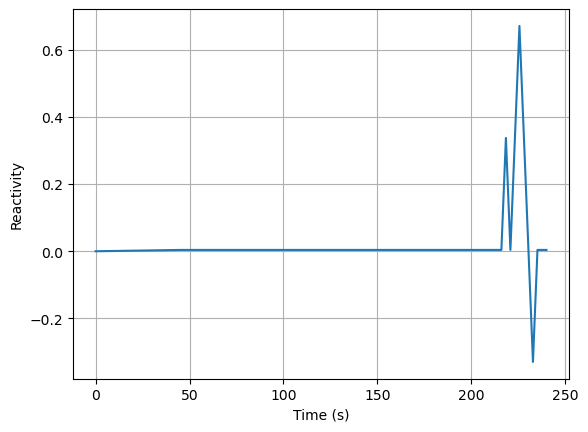

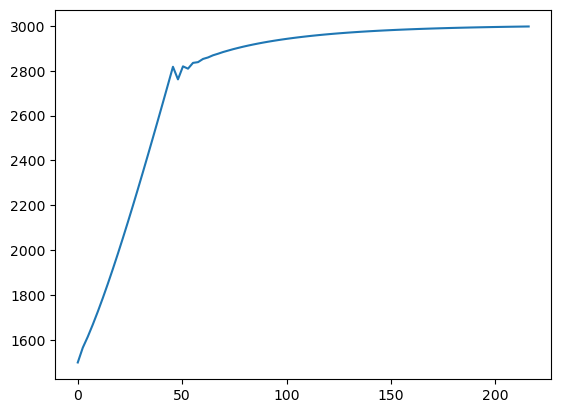

In [11]:
plt.figure(1)
plt.plot(timepoints, optimal_control.x)
plt.xlabel("Time (s)")
plt.ylabel("Reactivity")
plt.grid()

plt.figure(2)
X, T, rho, rhoF = SimpleTransient(timepoints, P0, optimal_control.x, PKE, TH, aF, 0.1E-05)
plt.plot(timepoints, X[0, :]/1E+06, label='Calculated')

_, T = find_final_time(X[0, :], P1, timepoints)
plt.axvline(T, label='Final time')
plt.axhline(P1/1E+06, linestyle='dashed' ,label="Desired power uprate")
plt.xlabel("Time (s)")
plt.ylabel("Power (MW)")
plt.grid()